<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/294_n2v_3D_multi_ch_czi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/uaa6GzmVLQo

**Denoising 2D/3D multi-channel scientific images using Noise2Void deep learning approach**

This example is for training a N2V denoising model using multichannel **3D CZI images**. The same approach can be taken for any scientific image in any format, as long as you have an appropriate library to read the files. To read CZI images, we will be using czifile library. 
<p>
Please note that CZI files are from ZEISS light microscopes. 



In [ ]:
#Install the tensorflow library suggested by N2V. 
! pip install tensorflow==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.7 MB 16 kB/s 
     |████████████████████████████████| 132 kB 55.7 MB/s 
     |████████████████████████████████| 3.8 MB 64.5 MB/s 
     |████████████████████████████████| 2.9 MB 58.6 MB/s 
     |████████████████████████████████| 462 kB 60.2 MB/s 
     |████████████████████████████████| 14.8 MB 57.8 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68723 sha256=c4f75fc74482597b8193b715c16b8c226e993e10642680a15d275c5869d75cb9
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

In [ ]:
#Install N2V
!pip install n2v

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 31.0 MB 60.4 MB/s 
     |████████████████████████████████| 109 kB 70.9 MB/s 
     |████████████████████████████████| 73 kB 2.8 MB/s 
     |████████████████████████████████| 377 kB 57.6 MB/s 
     |████████████████████████████████| 50 kB 8.5 MB/s 
     |████████████████████████████████| 546 kB 68.8 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
#Install czifile library (or other appropriate libraries, e.g., oiffile for Olympus images)
!pip install czifile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import n2v
import czifile
print(tf.__version__)
print(n2v.__version__)

2.4.0
0.3.1


In [ ]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**Training Data Preparation**


<p>

For training we can load a bunch of noisy images from a directory. Images can be of different sizes as we will be capturing them as a list, not an array. Of course, each image if reas as an array. 
<p>
We will then use the N2V_DataGenerator to extract training X and validation X_val patches.

We will use the czifile library to load images from a directory. <u>But first let us understand the dimensions of a CZI image as read by czifile library. </u>



In [ ]:
test_img = czifile.imread('/content/drive/MyDrive/ColabNotebooks/data/N2V/czi-img-z-stack/mitosis-LSM-z-stack.czi')
print("Shape of original image is: ", test_img.shape) # Our image is a 2 channel 3D image of dimensions 587 x 587 and 23 slices in Z
#Current shape is: (1, 1, 2, 23, 587, 587, 1) - We need to get it to a ZYXC shape
test_img = test_img[0,0,:,:,:,:,0]
print("Shape of the image after dropping some dims is: ", test_img.shape) #(2, 23, 587, 587)
test_img = np.moveaxis(test_img, 0, 3)
print("Shape of the image after moving axes is: ", test_img.shape) # (23, 587, 587, 2)

Shape of original image is:  (1, 1, 2, 23, 587, 587, 1)
Shape of the image after dropping some dims is:  (2, 23, 587, 587)
Shape of the image after moving axes is:  (23, 587, 587, 2)


Note that the images need to be in float32 format. We need to make sure they are converted to float32. 

In [ ]:

from skimage.io import imread
from skimage import img_as_float32
import glob

def load_images(path):
    image_list=[]
    images= glob.glob(path)

    for index in range(len(images)):
        image= czifile.imread(images[index])
        image = image[0,0,:,:,:,:,0]  #Pick the appropriate channels
        image = np.moveaxis(image, 0, 3)  #Swap axes to the right format ZYXC
        image = img_as_float32(image)  #Convert to float32
        image = np.expand_dims(image, axis=0)  #Expand dims to get it ready for neural network
        image_list.append(image)  #add images to our list

    return image_list

In [ ]:
#We only have a single image for now, so our list will have a length of 1
base_dir = '/content/drive/MyDrive/ColabNotebooks/data/N2V/czi-img-z-stack/*.czi'

imgs = load_images(base_dir)


In [ ]:
print(len(imgs)) #We only have a single image for now, so our list will have a length of 1
print(imgs[0].shape)
print(imgs[0].dtype)

1
(1, 23, 587, 587, 2)
float32


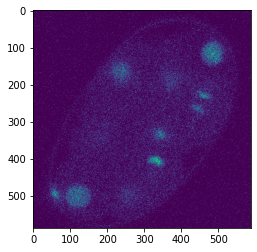

In [ ]:
# Let's look at the image.
plt.figure()
plt.imshow(imgs[0][0,12,:,:,1]) #Plot a single channel from a single slice to see if it looks ok
plt.show()

In [ ]:
# We create our DataGenerator-object.
# It will help us extract patches for training and validation.
datagen = N2V_DataGenerator()

In [ ]:
patch_size = 64

In [ ]:
# We will use the first image to extract training patches and store them in 'X'
patch_size_z = 8
patch_shape = (patch_size_z, patch_size, patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)


Generated patches: (1296, 8, 64, 64, 2)


In [ ]:
patches.shape

(1296, 8, 64, 64, 2)

In [ ]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
#Let us split into 80/20 for train/validation
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [ ]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

(1036, 8, 64, 64, 2)
float32
(260, 8, 64, 64, 2)


In [ ]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

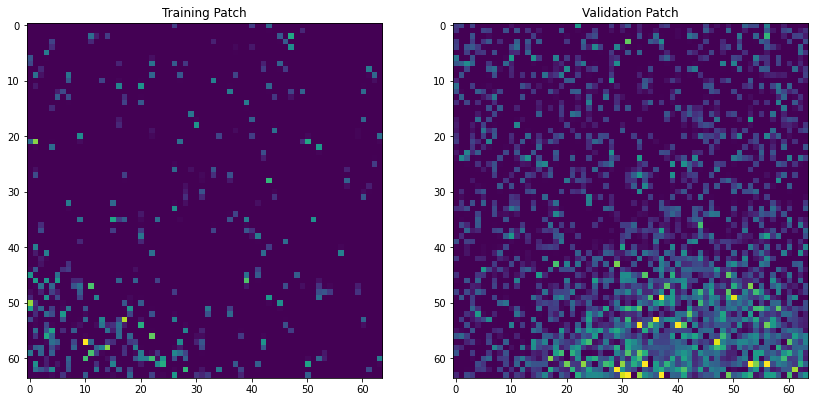

In [ ]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,0,:,:,1])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,0,:,:,1])
plt.title('Validation Patch');

<h2>Configure</h2><p>

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the N2VConfig constructor for a description of all parameters.
<p>
When creating the config-object, we provide the training data X. From X we extract mean and std that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from X.
<p>
Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased train_batch_size and batch_norm. To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter n2v_manipulator with default value 'uniform_withCP'. Most pixel manipulators will compute the replacement value based on a neighborhood. With n2v_neighborhood_radius we can control its size.
<p>
<h3>Other pixel manipulators:</h3>
<p>
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
<br>
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = n2v_neighborhood_radius
<br>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
<br>
* identity: performs no pixel manipulation
<br>
For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via n2v_perc_pix.
<p>
For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size n2v_patch_shape are extracted during training. Default patch shape is set to (64, 64).
<p>
In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the single_net_per_channel option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough.<br>
Note: Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.
<p>
**Warning:** to make this example notebook execute faster, we have set train_epochs to only around 10.
For better results we suggest 100 to 200 train_epochs.

In [ ]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
train_batch = 32
config = N2VConfig(X, unet_kern_size=3, 
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=5, train_loss='mse', 
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size_z, patch_size, patch_size), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.035883337', '0.03506415'],
 'stds': ['0.0743189', '0.093648516'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 2,
 'n_channel_out': 2,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 2),
 'train_loss': 'mse',
 'train_epochs': 5,
 'train_steps_per_epoch': 32,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (8, 64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [ ]:
# a name used to identify the model --> change this to something sensible!
model_name = 'n2v_3D_multi_ch_czi'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

<h2>Training</h2><p>


In [ ]:
# We are ready to start training now.
history = model.train(X, X_val)

64 blind-spots will be generated per training patch of size (8, 64, 64).


Preparing validation data: 100%|██████████| 260/260 [00:00<00:00, 1153.08it/s]


Epoch 1/5
 6/32 [====>.........................] - ETA: 40s - loss: 1.4497 - n2v_mse: 1.4497 - n2v_abs: 0.7627

32/32 [==============================] - 81s 2s/step - loss: 1.1580 - n2v_mse: 1.1580 - n2v_abs: 0.6572 - val_loss: 12.4883 - val_n2v_mse: 11.3582 - val_n2v_abs: 1.4577
Epoch 2/5
32/32 [==============================] - 60s 2s/step - loss: 0.7855 - n2v_mse: 0.7855 - n2v_abs: 0.5073 - val_loss: 1.0592 - val_n2v_mse: 0.9789 - val_n2v_abs: 0.5621
Epoch 3/5
32/32 [==============================] - 59s 2s/step - loss: 0.7583 - n2v_mse: 0.7583 - n2v_abs: 0.4798 - val_loss: 0.7171 - val_n2v_mse: 0.6729 - val_n2v_abs: 0.4382
Epoch 4/5
32/32 [==============================] - 59s 2s/step - loss: 0.7690 - n2v_mse: 0.7690 - n2v_abs: 0.5112 - val_loss: 0.6810 - val_n2v_mse: 0.6410 - val_n2v_abs: 0.4895
Epoch 5/5
32/32 [==============================] - 59s 2s/step - loss: 0.7227 - n2v_mse: 0.7227 - n2v_abs: 0.4826 - val_loss: 0.6668 - val_n2v_mse: 0.6281 - val_n2v_abs: 0.4157

Loading network weights from 'weights_best.h5'.


Plot loss vs. epoch

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


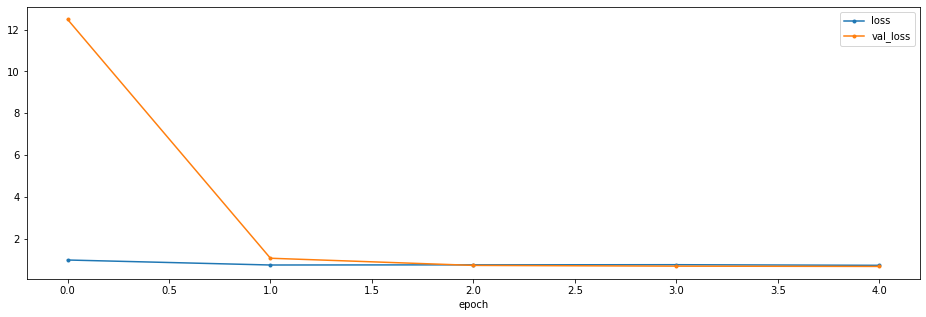

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

<h1>Denoising images using the trained model</h1>

In [ ]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [ ]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.  
model_name = 'n2v_3D_multi_ch_czi'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


Denoising (prediction)

In [ ]:
#Load and preprocess the image
test_img = czifile.imread('/content/drive/MyDrive/ColabNotebooks/data/N2V/czi-img-z-stack/mitosis-LSM-z-stack.czi')
test_img = test_img[0,0,:,:,:,:,0]
test_img = np.moveaxis(test_img, 0, 3)
test_img = img_as_float32(test_img)


In [ ]:
print(test_img.shape)
test_img.dtype

(23, 587, 587, 2)


dtype('float32')

In [ ]:

# Here we process the data.
# The parameter 'n_tiles' can be used if images are too big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred = model.predict(test_img, axes='ZYXC')

Out of memory, retrying with n_tiles = (1, 1, 2, 1)


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


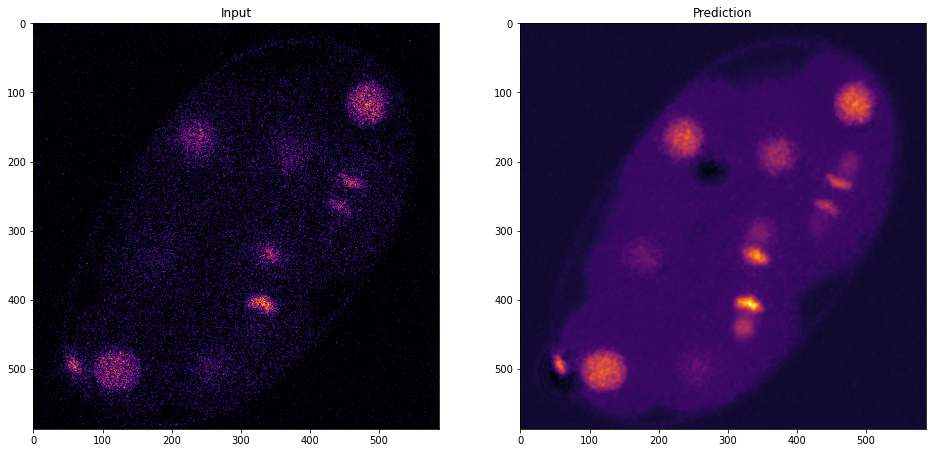

In [ ]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(test_img[12,:,:,1], cmap='inferno')
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred[12,:,:,1], cmap='inferno')
plt.title('Prediction');

**Saving results into a scientific image format (OMETIFF) using the apeer-ometiff-library**
<p>
Normal image viewing programs cannot handle images with multiple channels that are not RGB. Therefore, we need to save our result into a format that can be opened using scientific image handling programs like imageJ. Unfortunately, the results cannot be saved into propreitary formats as instrument vendors reserve the right to do so. Therefore, we will be saving our result as OMETIFF format that can handle multi dimensional data. 

In [ ]:
!pip install apeer-ometiff-library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.9 MB 3.6 MB/s 
     |████████████████████████████████| 133 kB 30.8 MB/s 
  Attempting uninstall: tifffile
    Found existing installation: tifffile 2021.11.2
    Uninstalling tifffile-2021.11.2:
      Successfully uninstalled tifffile-2021.11.2
  Attempting uninstall: imagecodecs
    Found existing installation: imagecodecs 2021.11.20
    Uninstalling imagecodecs-2021.11.20:
      Successfully uninstalled imagecodecs-2021.11.20


In [ ]:
from apeer_ometiff_library import io

In [ ]:
pred.shape

(23, 587, 587, 2)

In [ ]:
# Expand image array to 5D of order (T, Z, C, X, Y)
# This is the convention for OMETIFF format as written by APEER library
final_pred = np.expand_dims(pred, axis=0)
final_pred = np.swapaxes(final_pred, 4, 2)
final_pred = np.swapaxes(final_pred, 3, 4)  #Swap X and Y
#final_pred = final_pred.astype(np.int8)
print("Shape of the segmented volume is: T, Z, C, X, Y ", final_pred.shape)
print(final_pred.dtype)

Shape of the segmented volume is: T, Z, C, X, Y  (1, 23, 2, 587, 587)
float32


In [ ]:
# Write dataset as multi-dimensional OMETIFF *image*
io.write_ometiff("/content/drive/MyDrive/ColabNotebooks/data/N2V/denoised/denoised_z_stack_multi_channel.ome.tiff", final_pred)

Open the ometiff image in imagej or other scientific image processing software